In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.ticker as ticker
import shap

from sklearn import set_config
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error, r2_score


set_config(transform_output="pandas")

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
df = pd.read_csv('Final_predictions.csv')

In [2]:
df_building = df.copy()

In [3]:
# Sélectionner les colonnes numériques
numeric_col = df_building.select_dtypes(include=[np.number]).columns

# Afficher les noms des colonnes sélectionnées
print("Variables continue : " ,numeric_col)

Variables continue :  Index(['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
       'BuildingType_NonResidential', 'BuildingType_infrequent_sklearn',
       'PrimaryPropertyType_infrequent_sklearn',
       'ListOfAllPropertyUseTypes_infrequent_sklearn',
       'LargestPropertyUseType_infrequent_sklearn',
       'SecondLargestPropertyUseType_infrequent_sklearn',
       'ThirdLargestPropertyUseType_nan',
       'ThirdLargestPropertyUseType_infrequent_sklearn'],
      dtype='object')


In [4]:
# Sélection des colonnes pour l'entraînement
features = ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore',
       'BuildingType_NonResidential', 
       'ThirdLargestPropertyUseType_nan',
     
       ]

# Extraction des features et de la cible
X = df_building[features]
# Remplacer les valeurs manquantes par la moyenne de la variable cible
y = df_building['TotalGHGEmissions'].fillna(df_building['TotalGHGEmissions'].mean())

# Split en train et test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Elastic Net

In [29]:
# Transformer la variable cible et entraîner le modèle
model = ElasticNet()


# Création du DataFrame vide pour stocker les résultats
results_dfElasticNet = pd.DataFrame(columns=['scoring_name', 'best_score', 'min_test_score', 'min_test_score_time', 'train_scores', 'fit_time', 'split_score'])
param_grid = {
    'alpha': [0.001, 0.01, 0.1],
    'l1_ratio': [0.1, 0.3, 0.5]
}
scorings = {'mse': make_scorer(mean_squared_error), 
            'mape': make_scorer(mean_absolute_percentage_error),
            'r2': make_scorer(r2_score)}


# Boucle sur les mesures de performance
for scoring_name, scoring_func in scorings.items():
    # Initialisation de l'objet GridSearchCV
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring_func)

    # Entraînement du modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)

    # Meilleur score et hyperparamètres pour cette mesure de performance
    best_score = grid_search.best_score_
    
    # Score minimum de test
    min_test_score = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Temps correspondant au score minimum de test
    min_test_score_time = grid_search.cv_results_['mean_score_time'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Scores d'entraînement pour chaque répétition de validation croisée
    train_scores = grid_search.cv_results_['mean_fit_time']
    
    # Temps d'exécution pour chaque combinaison de paramètre
    fit_time = grid_search.cv_results_['std_fit_time']
    
    # Score pour chaque split de validation croisée
    split_score = grid_search.cv_results_['split0_test_score']
    
    # Ajout des résultats dans le DataFrame
    results_dfElasticNet = results_dfElasticNet.append({
        'scoring_name': scoring_name,
        'best_score': best_score,
        'min_test_score': min_test_score,
        'min_test_score_time': min_test_score_time,
        'train_scores': train_scores,
        'fit_time': fit_time,
        'split_score': split_score
    }, ignore_index=True)

# Affichage des résultats
print(results_dfElasticNet)

  scoring_name    best_score  min_test_score  min_test_score_time  \
0          mse  1.329383e+00    1.329383e+00             0.003202   
1         mape  2.913070e+13    2.913070e+13             0.002200   
2           r2  3.854525e-01    3.854525e-01             0.006000   

                                        train_scores  \
0  [0.008600330352783203, 0.009400606155395508, 0...   
1  [0.006399917602539063, 0.0051997661590576175, ...   
2  [0.00499725341796875, 0.004599332809448242, 0....   

                                            fit_time  \
0  [0.0028711625611475815, 0.0033820929737651702,...   
1  [0.0024163908122613923, 0.0007477300886682845,...   
2  [0.0010954997946872845, 0.0008000139880331881,...   

                                         split_score  
0  [1.3766066069653666, 1.375948520653971, 1.3752...  
1  [0.5165370049579937, 0.5164483036732308, 0.516...  
2  [0.3466410882949884, 0.3469534262963069, 0.347...  


In [30]:
# Prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Evaluation des performances sur les données de test
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAPE: ", mape)
print("R2: ", r2)

MSE:  1.3812234827704941
MAPE:  109842366456492.69
R2:  0.35303567310193074


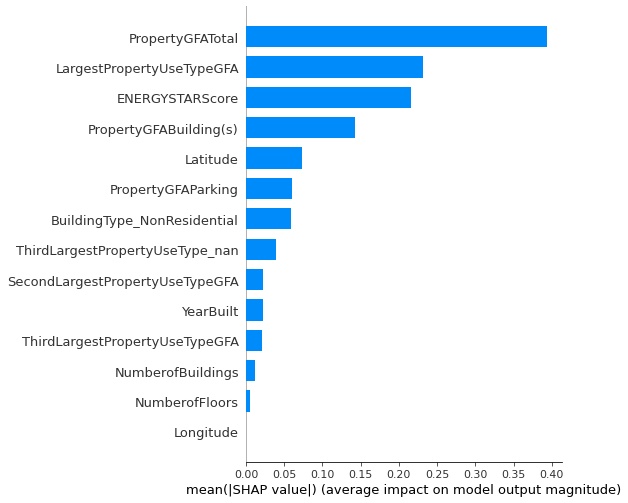

In [7]:
# Création de l'objet Explainer SHAP
explainer = shap.Explainer(grid_search.best_estimator_, X_train)

# Calcul des valeurs SHAP pour la colonne 'ENERGYSTARScore' dans les données d'entraînement
shap_values = explainer(X_train)

# Affichage du graphique SHAP pour la colonne 'ENERGYSTARScore'
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'])
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'], plot_type="bar")
shap.summary_plot(shap_values, X_train,plot_type="bar")

## RandomForest

In [31]:

# Création du DataFrame vide pour stocker les résultats
results_RandomForest = pd.DataFrame(columns=['scoring_name', 'best_score', 'min_test_score', 'min_test_score_time', 'train_scores', 'fit_time', 'split_score'])

# Liste des mesures de performance à tester
scorings = {'mse': make_scorer(mean_squared_error), 
            'mape': make_scorer(mean_absolute_percentage_error),
            'r2': make_scorer(r2_score)}

# Transformer la target variable et entraîner le modèle
rf = RandomForestRegressor()

# Grille de recherche pour les hyperparamètres
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10]
}

# Boucle sur les mesures de performance
for scoring_name, scoring_func in scorings.items():
    # Initialisation de l'objet GridSearchCV
    grid_search = GridSearchCV(rf, param_grid=params, cv=5, n_jobs=-1, scoring=scoring_func)

    # Entraînement du modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)

    # Meilleur score et hyperparamètres pour cette mesure de performance
    best_score = grid_search.best_score_
    
    # Score minimum de test
    min_test_score = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Temps correspondant au score minimum de test
    min_test_score_time = grid_search.cv_results_['mean_score_time'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Scores d'entraînement pour chaque répétition de validation croisée
    train_scores = grid_search.cv_results_['mean_fit_time']
    
    # Temps d'exécution pour chaque combinaison de paramètre
    fit_time = grid_search.cv_results_['std_fit_time']
    
    # Score pour chaque split de validation croisée
    split_score = grid_search.cv_results_['split0_test_score']
    
    # Ajout des résultats dans le DataFrame
    results_RandomForest = results_RandomForest.append({
        'scoring_name': scoring_name,
        'best_score': best_score,
        'min_test_score': min_test_score,
        'min_test_score_time': min_test_score_time,
        'train_scores': train_scores,
        'fit_time': fit_time,
        'split_score': split_score
    }, ignore_index=True)

# Affichage des résultats
print(results_RandomForest)


  scoring_name    best_score  min_test_score  min_test_score_time  \
0          mse  1.317929e+00    1.317929e+00             0.013201   
1         mape  2.802435e+13    2.802435e+13             0.021400   
2           r2  4.070929e-01    4.070929e-01             0.022196   

                                        train_scores  \
0  [0.20193853378295898, 0.4167614459991455, 0.81...   
1  [0.18085455894470215, 0.3530568599700928, 0.70...   
2  [0.17777791023254394, 0.35077271461486814, 0.6...   

                                            fit_time  \
0  [0.01277124262801298, 0.020938780796325742, 0....   
1  [0.011169486975200305, 0.007156140406565836, 0...   
2  [0.004735314733304865, 0.0037955292421577407, ...   

                                         split_score  
0  [1.3375130616690223, 1.3432672173975748, 1.351...  
1  [0.5225082296981541, 0.5183050264519329, 0.519...  
2  [0.3596423712053526, 0.36363080392440017, 0.36...  


In [32]:
# Prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Evaluation des performances sur les données de test
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAPE: ", mape)
print("R2: ", r2)

MSE:  1.4007588829473536
MAPE:  107300829603450.05
R2:  0.34388530230114234


In [23]:
results_RandomForest

,scoring_name,best_score,min_test_score,min_test_score_time,train_scores,fit_time,split_score
0,mse,1.320395e+00,1.320395e+00,0.005601,"[0.17899770736694337, 0.368999719619751, 0.800...","[0.006986654194239216, 0.02139202281348622, 0....","[1.334321836942932, 1.3570667629658524, 1.3494..."
1,mape,2.886491e+13,2.886491e+13,0.012601,"[0.3063993453979492, 0.4329989910125732, 0.751...","[0.02165633672894342, 0.05305446543285708, 0.0...","[0.524585485395419, 0.5218076397158397, 0.5216..."
2,r2,4.083003e-01,4.083003e-01,0.014001,"[0.25979862213134763, 0.40939717292785643, 0.7...","[0.03312621752770371, 0.015692396972481766, 0....","[0.3579665668191613, 0.35906805258374186, 0.36..."


## Gradient Boosting

In [34]:
results_GradientBoosting = pd.DataFrame(columns=['scoring_name', 'best_score', 'min_test_score', 'min_test_score_time', 'train_scores', 'fit_time', 'split_score'])

# Liste des mesures de performance à tester
scorings = {'mse': make_scorer(mean_squared_error), 
            'mape': make_scorer(mean_absolute_percentage_error),
            'r2': make_scorer(r2_score)}
# Configuration des hyperparamètres
params = {
    "learning_rate": [0.001,0.01,0.1],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10]
}
scoring_namesgb = []
best_scoresgb = []

# Instanciation du modèle
gb = GradientBoostingRegressor()

# Boucle sur les mesures de performance
for scoring_name, scoring_func in scorings.items():
    # Initialisation de l'objet GridSearchCV
    grid_search = GridSearchCV(gb, param_grid=params, cv=5, n_jobs=-1, scoring=scoring_func)

    # Entraînement du modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)
 # Meilleur score et hyperparamètres pour cette mesure de performance
    best_score = grid_search.best_score_
    
    # Score minimum de test
    min_test_score = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Temps correspondant au score minimum de test
    min_test_score_time = grid_search.cv_results_['mean_score_time'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Scores d'entraînement pour chaque répétition de validation croisée
    train_scores = grid_search.cv_results_['mean_fit_time']
    
    # Temps d'exécution pour chaque combinaison de paramètre
    fit_time = grid_search.cv_results_['std_fit_time']
    
    # Score pour chaque split de validation croisée
    split_score = grid_search.cv_results_['split0_test_score']
    
    # Ajout des résultats dans le DataFrame
    results_GradientBoosting = results_GradientBoosting.append({
        'scoring_name': scoring_name,
        'best_score': best_score,
        'min_test_score': min_test_score,
        'min_test_score_time': min_test_score_time,
        'train_scores': train_scores,
        'fit_time': fit_time,
        'split_score': split_score
    }, ignore_index=True)

# Affichage des résultats
print(results_GradientBoosting)


  scoring_name    best_score  min_test_score  min_test_score_time  \
0          mse  2.066072e+00    2.066072e+00             0.003200   
1         mape  3.059676e+13    3.059676e+13             0.003400   
2           r2  4.022155e-01    4.022155e-01             0.002399   

                                        train_scores  \
0  [0.20282063484191895, 0.43836307525634766, 0.8...   
1  [0.2057652473449707, 0.4208055019378662, 1.008...   
2  [0.2108529567718506, 0.5112692832946777, 0.990...   

                                            fit_time  \
0  [0.006483255217970357, 0.016504689710377538, 0...   
1  [0.002863648457645185, 0.01991537084883516, 0....   
2  [0.020336109481707887, 0.029097210188845955, 0...   

                                         split_score  
0  [2.0897052176587017, 2.0292978863114626, 1.921...  
1  [0.6502018354340359, 0.6425146745864515, 0.627...  
2  [0.008193393896646306, 0.03686365311837114, 0....  


In [35]:
# Prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Evaluation des performances sur les données de test
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAPE: ", mape)
print("R2: ", r2)

MSE:  1.384824816499203
MAPE:  111288919335352.5
R2:  0.35134881034525645


In [27]:
# Créer un dictionnaire de tableaux de scores pour chaque modèle
scores_dict = {
    'Elastic Net': results_dfElasticNet,
    'Random Forest': results_RandomForest,
    'Gradient Boosting': results_GradientBoosting
}

# Concaténer les tableaux de scores en un seul tableau
scores_df = pd.concat(scores_dict.values(), keys=scores_dict.keys())

# Nommer l'index et les colonnes
scores_df.index.names = ['Model', 'Metric']




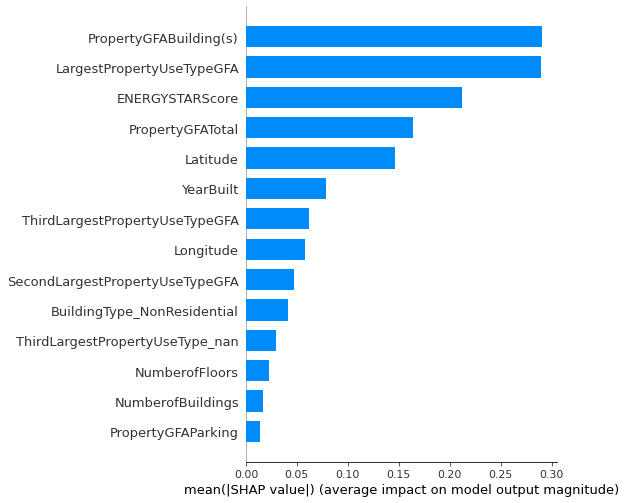

In [17]:
# Création de l'objet Explainer SHAP
explainer = shap.Explainer(grid_search.best_estimator_, X_train)

# Calcul des valeurs SHAP pour la colonne 'ENERGYSTARScore' dans les données d'entraînement
shap_values = explainer(X_train)

# Affichage du graphique SHAP pour la colonne 'ENERGYSTARScore'
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'])
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'], plot_type="bar")
shap.summary_plot(shap_values, X_train,plot_type="bar")

In [28]:
scores_df

scoring_name    best_score  min_test_score  \
Model             Metric                                              
Elastic Net       0               mse  1.329383e+00    1.329383e+00   
                  1              mape  2.913070e+13    2.913070e+13   
                  2                r2  3.854525e-01    3.854525e-01   
Random Forest     0               mse  1.320395e+00    1.320395e+00   
                  1              mape  2.886491e+13    2.886491e+13   
                  2                r2  4.083003e-01    4.083003e-01   
Gradient Boosting 0               mse  2.066072e+00    2.066072e+00   
                  1              mape  3.049321e+13    3.049321e+13   
                  2                r2  4.021792e-01    4.021792e-01   

                          min_test_score_time  \
Model             Metric                        
Elastic Net       0                  0.003599   
                  1                  0.003400   
                  2                  0.003400   
Random Forest     0                  0.005601   
                  1                  0.012601   
                  2                  0.014001   
Gradient Boosting 0                  0.002401   
                  1                  0.003401   
                  2                  0.002600   

                                                               train_scores  \
Model             Metric                                                      
Elastic Net       0       [0.008397197723388672, 0.007799482345581055, 0...   
                  1       [0.006199502944946289, 0.005201482772827148, 0...   
                  2       [0.005798768997192383, 0.005399465560913086, 0...   
Random Forest     0       [0.17899770736694337, 0.368999719619751, 0.800...   
                  1       [0.3063993453979492, 0.4329989910125732, 0.751...   
                  2       [0.25979862213134763, 0.40939717292785643, 0.7...   
Gradient Boosting 0       [0.20459818840026855, 0.438599157333374, 0.932...   
                  1       [0.19659852981567383, 0.39619922637939453, 0.7...   
                  2       [0.19719815254211426, 0.3957979679107666, 0.79...   

                                                                   fit_time  \
Model             Metric                                                      
Elastic Net       0       [0.002941291648718861, 0.0009816814348815497, ...   
                  1       [0.0015993238106303206, 0.0009804671520866285,...   
                  2       [0.0009793657436247044, 0.0004896875475772443,...   
Random Forest     0       [0.006986654194239216, 0.02139202281348622, 0....   
                  1       [0.02165633672894342, 0.05305446543285708, 0.0...   
                  2       [0.03312621752770371, 0.015692396972481766, 0....   
Gradient Boosting 0       [0.00488289538467736, 0.027658783668890092, 0....   
                  1       [0.0017442865537803005, 0.0030593583595849355,...   
                  2       [0.0036555313441397133, 0.000980299209487423, ...   

                                                                split_score  
Model             Metric                                                     
Elastic Net       0       [1.3766066069653666, 1.375948520653971, 1.3752...  
                  1       [0.5165370049579937, 0.5164483036732308, 0.516...  
                  2       [0.3466410882949884, 0.3469534262963069, 0.347...  
Random Forest     0       [1.334321836942932, 1.3570667629658524, 1.3494...  
                  1       [0.524585485395419, 0.5218076397158397, 0.5216...  
                  2       [0.3579665668191613, 0.35906805258374186, 0.36...  
Gradient Boosting 0       [2.0897052176587017, 2.0292978863114626, 1.921...  
                  1       [0.6502018354340359, 0.6425146745864515, 0.627...  
                  2       [0.008193393896646306, 0.03686365311837114, 0....